# DeepLearning 04. Restricted Boltzmann Machines (RBM) and Autoencoder

* **Implementation 5a**: RBM with Tensorflow
    * Reconstructing MNIST images.

* **Implementation 5b**: Autoencoder with Tensorflow
    * TBD

## I. Implementation 5a

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# LOAD DATA

path = "/Users/jacobsw/Desktop/UNIV/SPRING_2017/LIN389C_RSCH_COMPLING/CODE/MNIST/"
mnist = input_data.read_data_sets(path, one_hot=True)
X_train, X_test = mnist.train.images, mnist.test.images

Extracting /Users/jacobsw/Desktop/UNIV/SPRING_2017/LIN389C_RSCH_COMPLING/CODE/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/jacobsw/Desktop/UNIV/SPRING_2017/LIN389C_RSCH_COMPLING/CODE/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/jacobsw/Desktop/UNIV/SPRING_2017/LIN389C_RSCH_COMPLING/CODE/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/jacobsw/Desktop/UNIV/SPRING_2017/LIN389C_RSCH_COMPLING/CODE/MNIST/t10k-labels-idx1-ubyte.gz


Cost at the first run:  0.481142

Epoch: 0 reconstruction cost: 0.062787
Epoch: 1 reconstruction cost: 0.051647
Epoch: 2 reconstruction cost: 0.049446
Epoch: 3 reconstruction cost: 0.046157
Epoch: 4 reconstruction cost: 0.045261


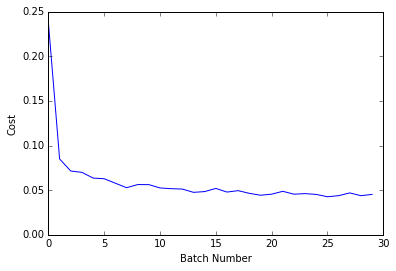

In [17]:
# BUILD GRAPH

vb = tf.placeholder('float', [784]) # 784-unit bias at input layer.
hb = tf.placeholder('float', [500]) # 500-unit bias at hidden/abstraction layer.

# weights
#   updated with Contrastive Divergence (CD): 
#   W' = W + alpha*CD, where CD = (pos_grad-neg_grad)/num_data.
W = tf.placeholder('float', [784, 500]) # weight/projection matrix from input to hidden layer.

# forward pass (positive phase)
#   goal: increase the probability of training data.
v0 = tf.placeholder('float', [None, 784]) # input of unspecified batch size.
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb) # prob of hidden units. (dims: ? x 784 * 784 x 500 + 500)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) # sampling (h given v) (SEE APPENDIX). 

# backward pass (negative phase)
#   goal: decrease the probability of the samples generated by the model.
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) # prob of input units. (dims: 500 * 500 x 784 + 784)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) # sampling (v given h).

# second round ...
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb) # NB: the same weights. (dims: 784 * 784 x 500 + 500)

alpha = 1.
w_pos_grad = tf.matmul(tf.transpose(v0), h0) # v0: contains prob_true; h0: contains positive samples.
w_neg_grad = tf.matmul(tf.transpose(v1), h1) # v1: contains negative samples (from hidden); h1: constructed from negs
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0]) # Contrastive Divergence (CD).
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

cost = tf.reduce_mean(tf.square(v0 - v1))

# TRAINING

# initialization
cur_w = np.zeros([784, 500], np.float32) # NB: only one set of weights, init with 0 is fine.
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([500], np.float32)
prv_w = np.zeros([784, 500], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([500], np.float32)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
print "Cost at the first run: ", sess.run(cost, feed_dict={v0:X_train, W:prv_w, vb:prv_vb, hb:prv_hb})
print

epochs = 5
batchsize = 100
weights = []
costs = []

for epoch in range(epochs):
    for start,end in zip(range(0,len(X_train),batchsize),range(batchsize,len(X_train),batchsize)):
        batch = X_train[start:end]
        cur_w = sess.run(update_w, feed_dict={v0:batch, W:prv_w, vb:prv_vb, hb:prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0:batch, W:prv_w, vb:prv_vb, hb:prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0:batch, W:prv_w, vb:prv_vb, hb:prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            costs.append(sess.run(cost, feed_dict={v0:batch, W:prv_w, vb:prv_vb, hb:prv_hb}))
            weights.append(cur_w)
    print 'Epoch: %d' % epoch, 'reconstruction cost: %f' % costs[-1]

plt.plot(costs)
plt.xlabel('Batch Number')
plt.ylabel('Cost')
plt.show()

Input Image:



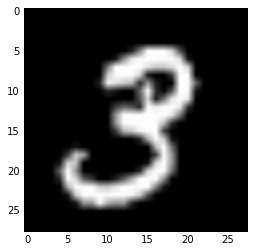


Reconstructed Image:



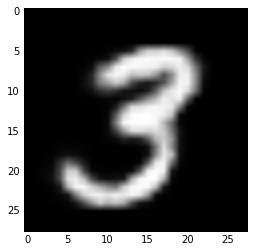

In [18]:
# PREDICTION

print "Input Image:\n"
img_in = X_train[1:2].reshape(28,28) # trX[1:2] returns shape (1,784), satisfying v0's required shape [None, 784].
plt.imshow(img_in, cmap='gray')
plt.show()
print

# pass original image through trained RBM
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0:X_train[1:2], W:prv_w, hb:prv_hb})
rec = sess.run(vv1, feed_dict={hh0:feed, W:prv_w, vb:prv_vb})

print "Reconstructed Image:\n"
img_out = rec.reshape(28,28)
plt.imshow(img_out, cmap='gray')

sess.close()

In [13]:
# APPENDIX: SAMPLING

with tf.Session() as sess:
    a = tf.constant([0.7, 0.1, 0.8, 0.2]) # it's setup s.t. 0,2 are more likely to be sampled, and 1,3 less likely.
    print sess.run(a)
    b = sess.run(tf.random_uniform(tf.shape(a))) # now sample from a length-4 uniform list (4 values between [0,1]).
    print b
    print sess.run( a - b ) # if a[i] is big, it is more likely to be positive here (on the 'sampled side').
    print sess.run(tf.sign( a - b)) # if a value is sampled, use 1 to mark it, otherwise use -1.
    print sess.run(tf.nn.relu(tf.sign( a - b))) # turn all -1 marked values to 0, 1 marked to 1.
        # result: a list of values (0 or 1), 1's are sampled ones.

[ 0.69999999  0.1         0.80000001  0.2       ]
[ 0.01756859  0.88238037  0.43475688  0.24791288]
[ 0.6824314  -0.78238034  0.36524314 -0.04791288]
[ 1. -1.  1. -1.]
[ 1.  0.  1.  0.]
